<a href="https://colab.research.google.com/github/wolfram-laube/clarissa/blob/feature%2Fvoice-roundtrip-notebook/notebooks/spe_benchmark_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 CLARISSA · SPE Benchmark Cross-Validation

**Real OPM Flow 2025.10 simulation results** from the Nordic VM.

| Benchmark | Grid | Cells | Wells | Description |
|-----------|------|-------|-------|-------------|
| SPE1 | 10×10×3 | 300 | 2 | Gas injection, 3φ black-oil (Odeh 1981) |
| SPE5 | 7×7×3 | 147 | 3 | WAG miscible flood (Killough 1987) |
| SPE9 | 24×25×15 | 9,000 | 26 | Heterogeneous corner-point (Killough 1995) |
| SPE10 M1 | 100×1×20 | 2,000 | 2 | 2D upscaling benchmark (Christie & Blunt 2001) |

---
*PAL Architecture · ICE v2.1 · ADR-040*

In [1]:
# Setup — install dependencies (Colab-friendly)
import sys, os
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q matplotlib numpy requests
    # Download results JSON from GitHub release/raw
    import requests as req
    url = 'https://raw.githubusercontent.com/wolfram-laube/clarissa/main/notebooks/data/spe_benchmarks_real.json'
    r = req.get(url)
    if r.status_code == 200:
        with open('spe_benchmarks_real.json', 'wb') as f: f.write(r.content)
        print(f'✓ Downloaded {len(r.content)/1024:.0f} KB from GitHub')
    else:
        print(f'⚠ Download failed ({r.status_code}). Clone repo: !git clone https://github.com/wolfram-laube/clarissa.git')
else:
    # Local / Nordic VM — add venv to path if needed
    for pv in ['3.10','3.11','3.12','3.13']:
        sp = os.path.expanduser(f'~/venv/lib/python{pv}/site-packages')
        if os.path.exists(sp): sys.path.insert(0, sp)

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path

plt.style.use('dark_background')
plt.rcParams.update({'figure.figsize': (14, 5), 'font.size': 11, 'axes.grid': True,
                     'grid.alpha': 0.2, 'figure.facecolor': '#0f0f1a',
                     'axes.facecolor': '#1a1a2e', 'savefig.facecolor': '#0f0f1a'})

CYAN, PURPLE, GREEN, RED, YELLOW = '#22d3ee', '#a78bfa', '#34d399', '#f87171', '#fbbf24'
print(f'Environment: {"Colab" if IN_COLAB else "Local"}')

✓ Downloaded 6189 KB from GitHub
Environment: Colab


## 1. Load Simulation Data

In [2]:
# Search for benchmark JSON in common locations
candidates = [
    Path('spe_benchmarks_real.json'),                                        # Colab download
    Path('notebooks/data/spe_benchmarks_real.json'),                          # Repo root
    Path('../notebooks/data/spe_benchmarks_real.json'),                       # From notebooks/
    Path.home() / 'projects/results/spe_benchmarks_real.json',                # Nordic VM
]

data = None
for p in candidates:
    if p.exists():
        with open(p) as f:
            data = json.load(f)
        print(f'✓ Loaded: {p} ({p.stat().st_size/1024:.0f} KB)')
        break

if not data:
    raise FileNotFoundError('No benchmark JSON found. Run Cell 1 in Colab or provide spe_benchmarks_real.json')

benchmarks = data['benchmarks']
print(f'Benchmarks: {list(benchmarks.keys())}\n')
for idx in data['index']:
    bm = benchmarks[idx['id']]
    ts = bm['opm']['timesteps']
    g = bm['grid']
    print(f"  {idx['id']:8s} {g['nx']}×{g['ny']}×{g['nz']:>2d} = {g['nx']*g['ny']*g['nz']:>5d} cells  "
          f"{len(ts):2d} steps  {ts[-1]['time_days']:.0f}d")

✓ Loaded: spe_benchmarks_real.json (6189 KB)
Benchmarks: ['SPE1', 'SPE5', 'SPE9', 'SPE10']

  SPE1     10×10× 3 =   300 cells  12 steps  3650d
  SPE5     7×7× 3 =   147 cells  12 steps  8034d
  SPE9     24×25×15 =  9000 cells  13 steps  900d
  SPE10    100×1×20 =  2000 cells  12 steps  8000d


## 2. Production Profiles — All Benchmarks

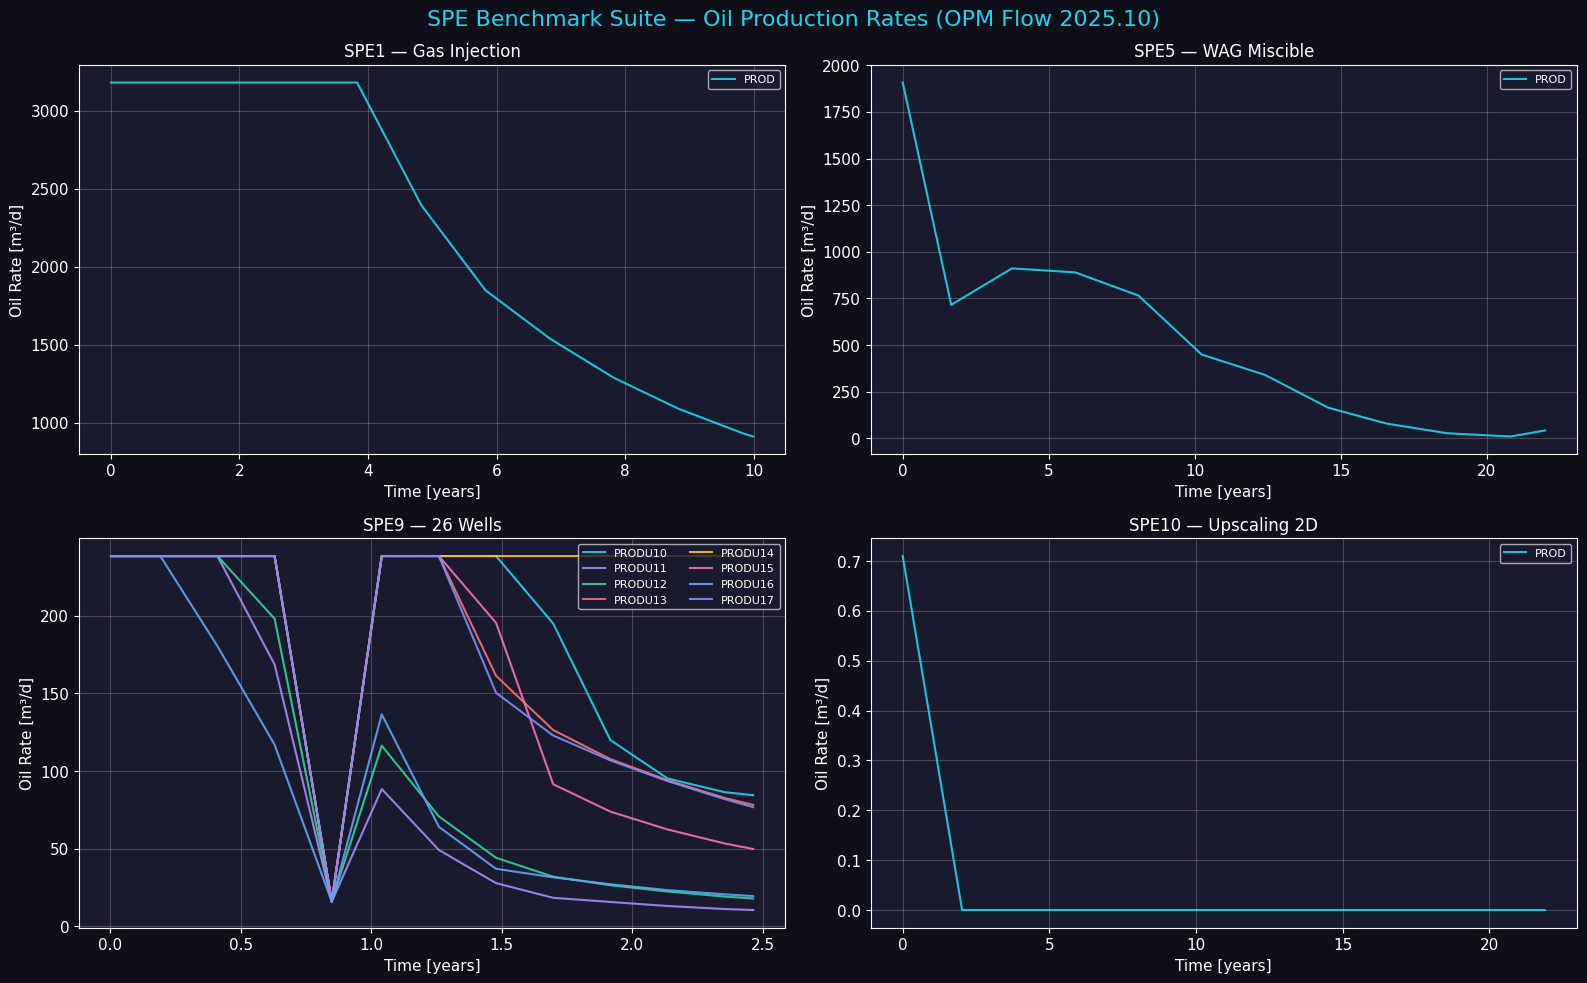

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('SPE Benchmark Suite — Oil Production Rates (OPM Flow 2025.10)',
             fontsize=16, color=CYAN, y=0.98)

configs = [('SPE1','Gas Injection',axes[0,0]), ('SPE5','WAG Miscible',axes[0,1]),
           ('SPE9','26 Wells',axes[1,0]), ('SPE10','Upscaling 2D',axes[1,1])]
colors = [CYAN, PURPLE, GREEN, RED, YELLOW, '#f472b6', '#60a5fa', '#818cf8']

for bm_id, subtitle, ax in configs:
    if bm_id not in benchmarks: continue
    ts = benchmarks[bm_id]['opm']['timesteps']
    wells = sorted({w['well_name'] for t in ts for w in t['wells'] if w.get('oil_rate_m3_day',0) > 0})

    for wi, wn in enumerate(wells[:8]):
        times = [t['time_days']/365.25 for t in ts]
        rates = [next((w.get('oil_rate_m3_day',0) for w in t['wells'] if w['well_name']==wn), 0) for t in ts]
        ax.plot(times, rates, color=colors[wi%len(colors)], lw=1.5, label=wn, alpha=0.9)

    ax.set_title(f'{bm_id} — {subtitle}', fontsize=12, color='white')
    ax.set_xlabel('Time [years]'); ax.set_ylabel('Oil Rate [m³/d]')
    ax.legend(fontsize=8, loc='upper right', ncol=2 if len(wells)>4 else 1)

plt.tight_layout()
plt.savefig('spe_production_rates.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Pressure Evolution — SPE1 Gas Injection

/tmp/ipython-input-437186863.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig('spe1_pressure.png', dpi=150, bbox_inches='tight'); plt.show()


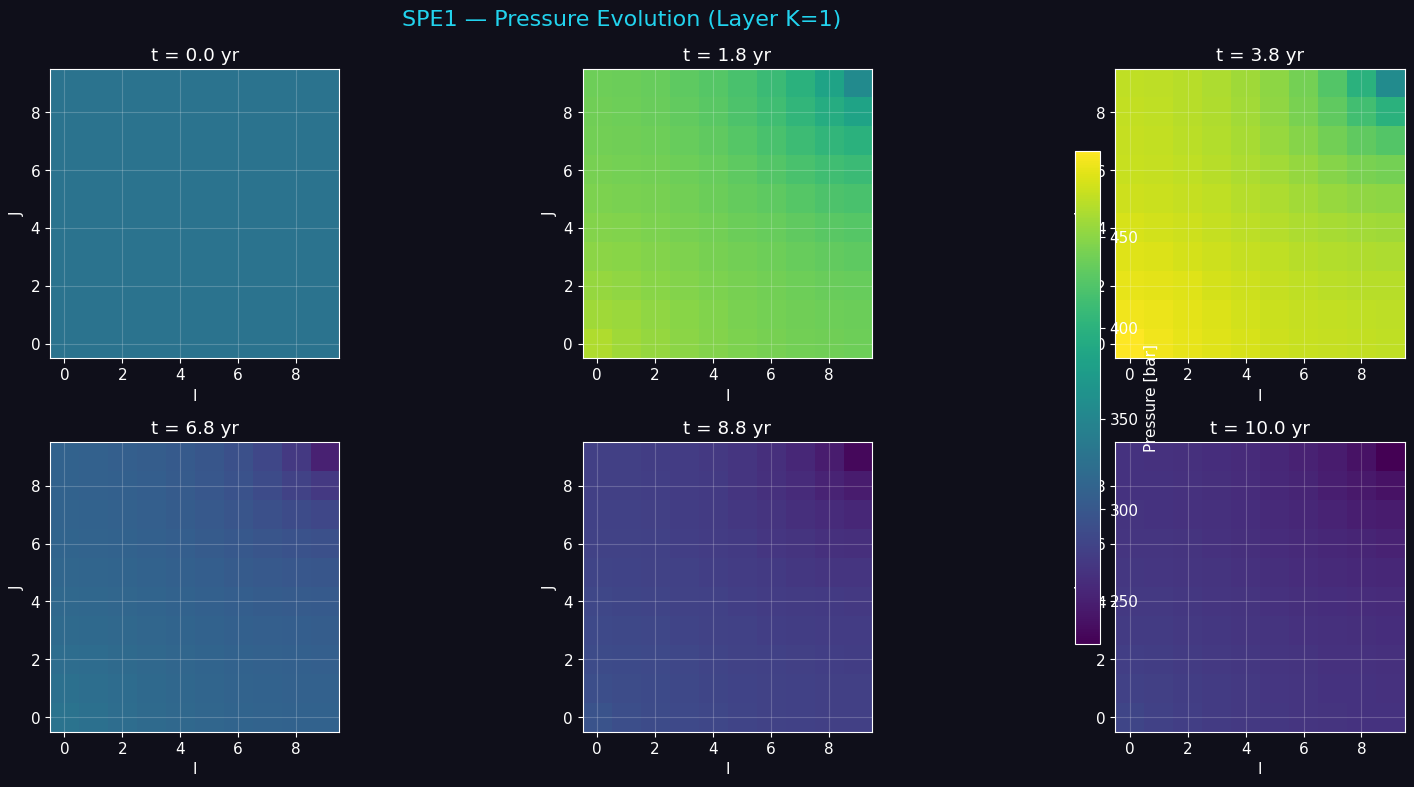

Range: 226.0 — 497.3 bar


In [4]:
bm = benchmarks['SPE1']
ts = bm['opm']['timesteps']
nx, ny, nz = bm['grid']['nx'], bm['grid']['ny'], bm['grid']['nz']
n = len(ts)
sel = [0, n//5, 2*n//5, 3*n//5, 4*n//5, n-1]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('SPE1 — Pressure Evolution (Layer K=1)', fontsize=16, color=CYAN)

all_p = [p for i in sel for p in ts[i]['cells']['pressure']]
vmin, vmax = min(all_p), max(all_p)

for si, ax in zip(sel, axes.flat):
    p = np.array(ts[si]['cells']['pressure']).reshape(nz, ny, nx)
    im = ax.imshow(p[0], cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_title(f't = {ts[si]["time_days"]/365.25:.1f} yr'); ax.set_xlabel('I'); ax.set_ylabel('J')

fig.colorbar(im, ax=axes, label='Pressure [bar]', shrink=0.8)
plt.tight_layout(); plt.savefig('spe1_pressure.png', dpi=150, bbox_inches='tight'); plt.show()
print(f'Range: {vmin:.1f} — {vmax:.1f} bar')

## 4. Gas Saturation Front — SPE1

/tmp/ipython-input-3349829701.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig('spe1_gas_front.png', dpi=150, bbox_inches='tight'); plt.show()


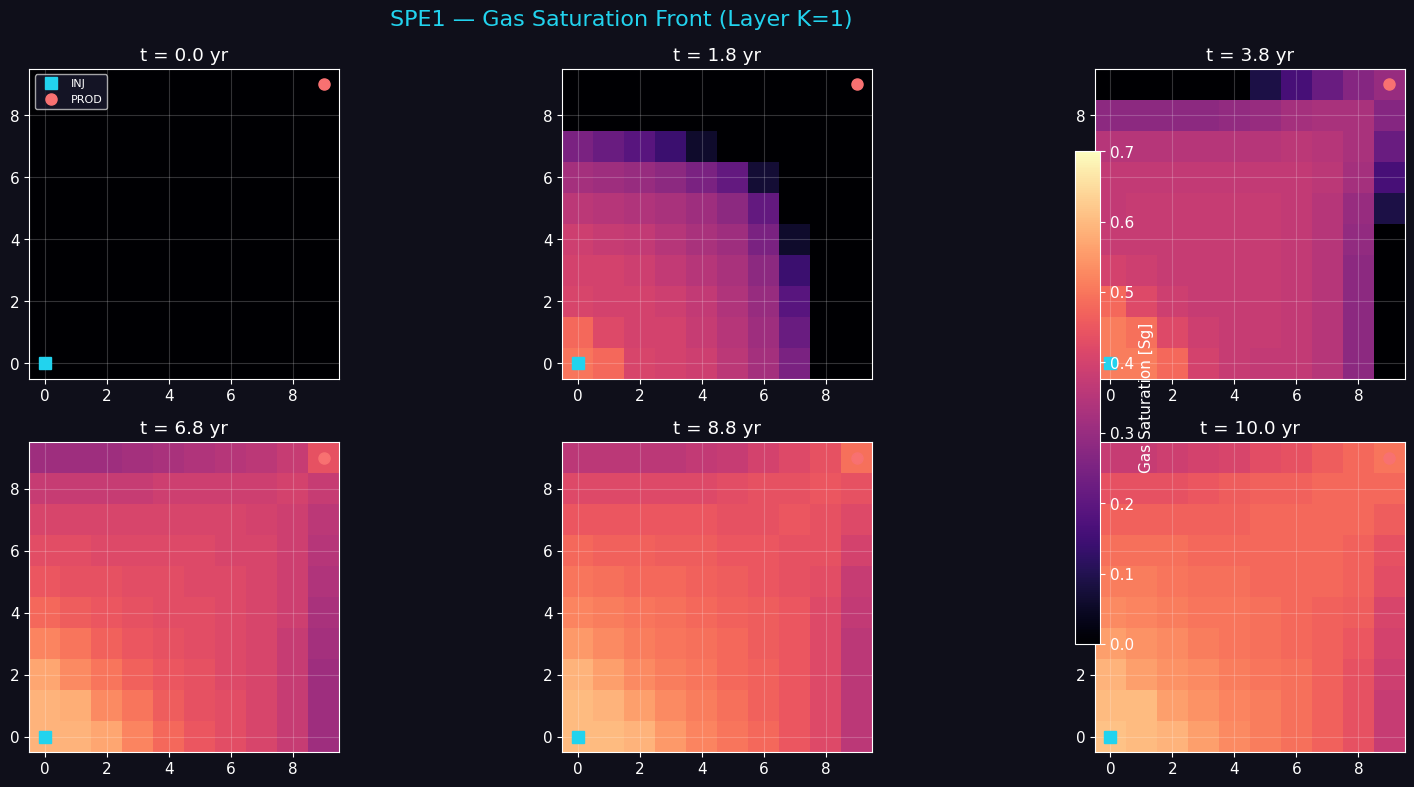

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('SPE1 — Gas Saturation Front (Layer K=1)', fontsize=16, color=CYAN)

for idx, (si, ax) in enumerate(zip(sel, axes.flat)):
    sg = np.array(ts[si]['cells']['saturation_gas']).reshape(nz, ny, nx)
    im = ax.imshow(sg[0], cmap='magma', vmin=0, vmax=0.7, origin='lower')
    ax.set_title(f't = {ts[si]["time_days"]/365.25:.1f} yr')
    ax.plot(0, 0, 's', color=CYAN, ms=8, label='INJ')
    ax.plot(9, 9, 'o', color=RED, ms=8, label='PROD')
    if idx == 0: ax.legend(fontsize=8)

fig.colorbar(im, ax=axes, label='Gas Saturation [Sg]', shrink=0.8)
plt.tight_layout(); plt.savefig('spe1_gas_front.png', dpi=150, bbox_inches='tight'); plt.show()

## 5. SPE9 — Permeability Heterogeneity (15 Layers)

/tmp/ipython-input-259643271.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig('spe9_permeability.png', dpi=150, bbox_inches='tight'); plt.show()


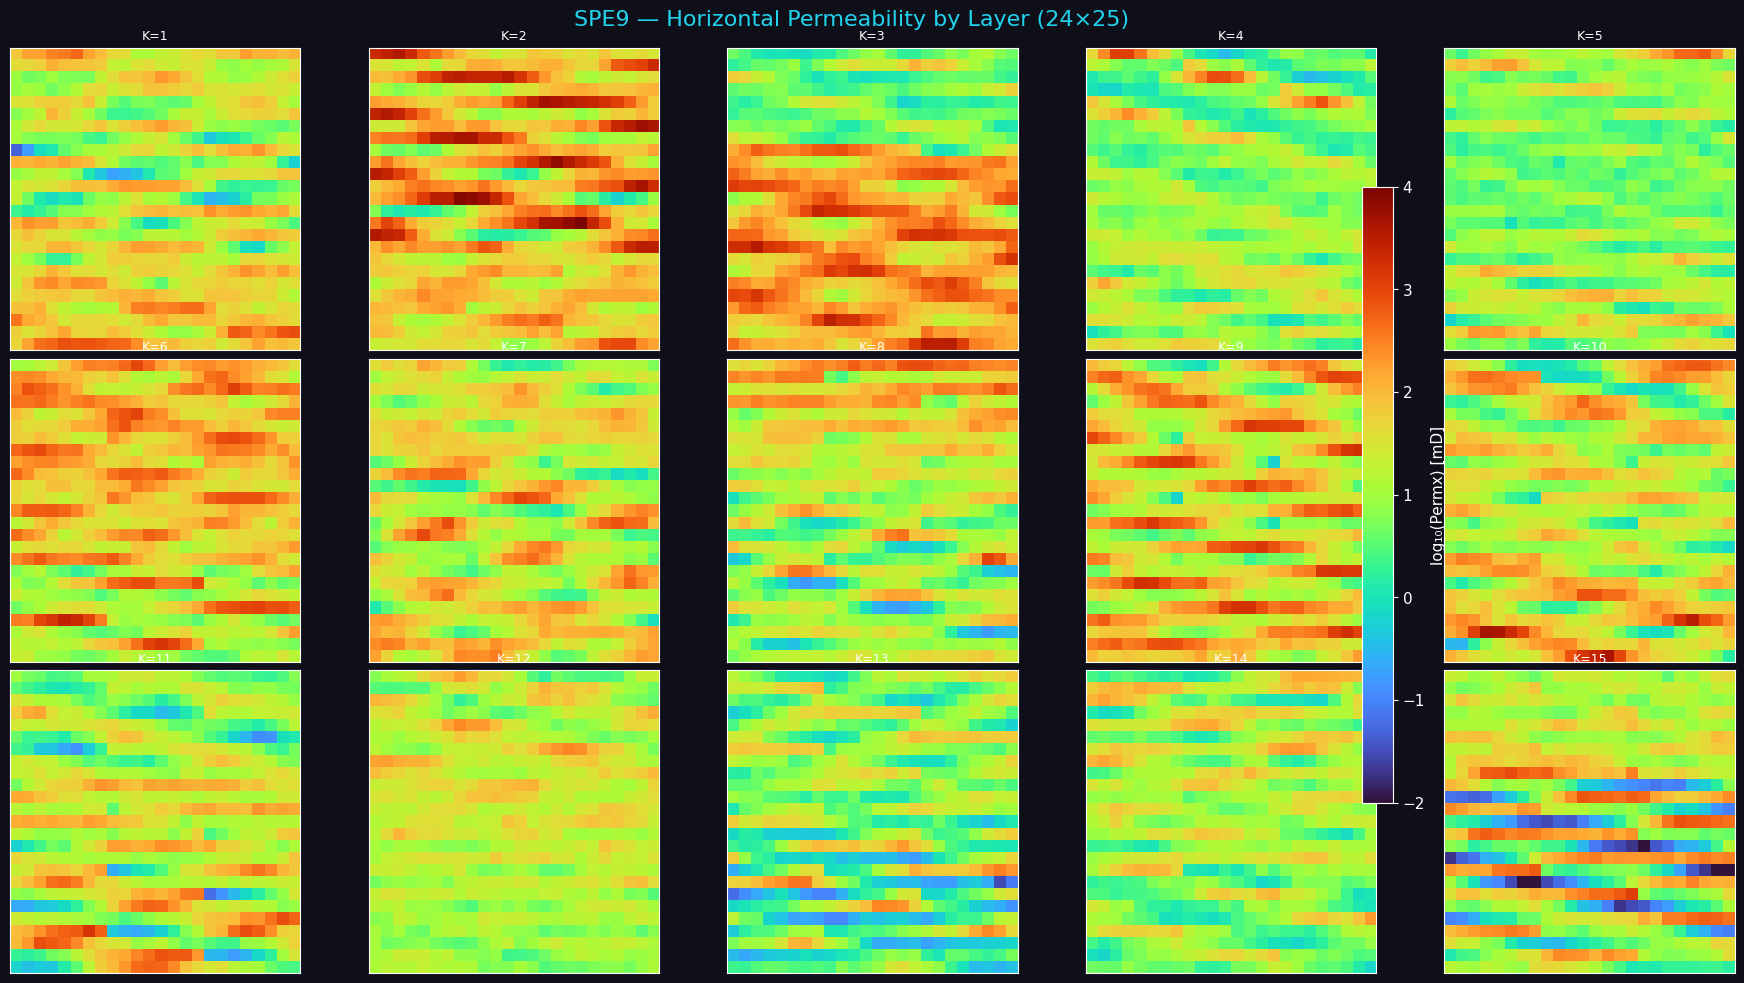

Permx: 0.0 — 10054 mD (2334 unique)


In [6]:
bm9 = benchmarks['SPE9']
nx9, ny9, nz9 = bm9['grid']['nx'], bm9['grid']['ny'], bm9['grid']['nz']
permx = np.array(bm9['grid']['permx']).reshape(nz9, ny9, nx9)
permx_log = np.log10(np.clip(permx, 0.01, None))

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle('SPE9 — Horizontal Permeability by Layer (24×25)', fontsize=16, color=CYAN)

for k in range(15):
    ax = axes[k//5, k%5]
    im = ax.imshow(permx_log[k], cmap='turbo', vmin=permx_log.min(), vmax=permx_log.max(), origin='lower')
    ax.set_title(f'K={k+1}', fontsize=9); ax.set_xticks([]); ax.set_yticks([])

fig.colorbar(im, ax=axes, label='log₁₀(Permx) [mD]', shrink=0.8)
plt.tight_layout(); plt.savefig('spe9_permeability.png', dpi=150, bbox_inches='tight'); plt.show()
print(f'Permx: {permx.min():.1f} — {permx.max():.0f} mD ({len(np.unique(np.round(permx,1)))} unique)')

## 6. SPE10 M1 — 2D Cross-Section

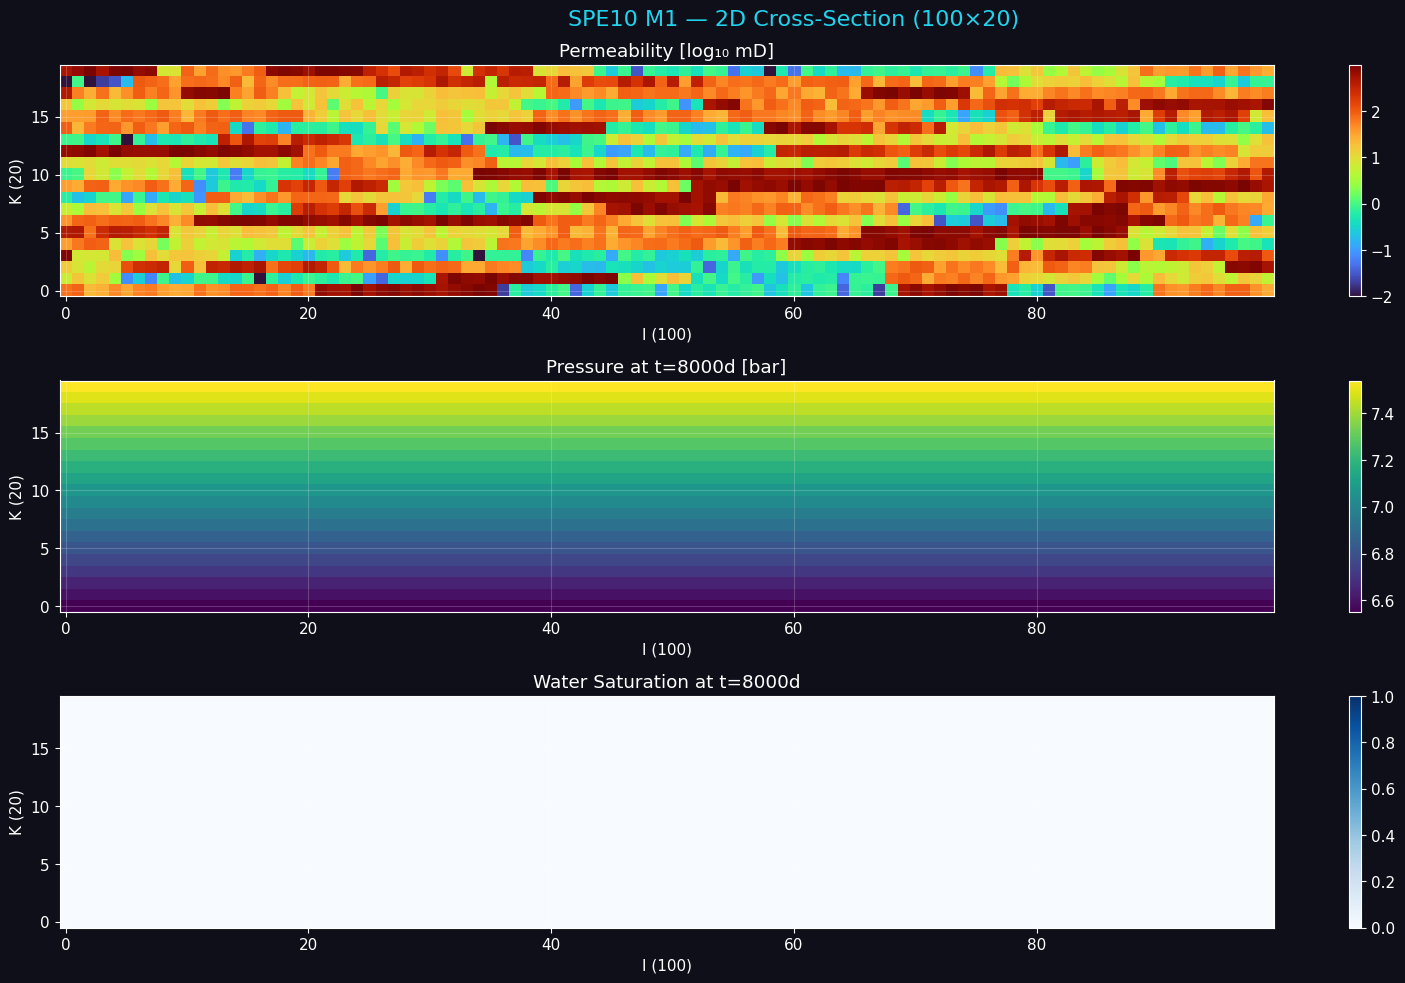

In [7]:
bm10 = benchmarks['SPE10']
nx10, ny10, nz10 = bm10['grid']['nx'], bm10['grid']['ny'], bm10['grid']['nz']
ts10 = bm10['opm']['timesteps']
perm10 = np.array(bm10['grid']['permx']).reshape(nz10, ny10, nx10)[:, 0, :]

fig, axes = plt.subplots(3, 1, figsize=(16, 10))
fig.suptitle('SPE10 M1 — 2D Cross-Section (100×20)', fontsize=16, color=CYAN)

im0 = axes[0].imshow(np.log10(np.clip(perm10, 0.01, None)), cmap='turbo', aspect='auto', origin='lower')
axes[0].set_title('Permeability [log₁₀ mD]'); fig.colorbar(im0, ax=axes[0])

p_final = np.array(ts10[-1]['cells']['pressure']).reshape(nz10, ny10, nx10)[:, 0, :]
im1 = axes[1].imshow(p_final, cmap='viridis', aspect='auto', origin='lower')
axes[1].set_title(f'Pressure at t={ts10[-1]["time_days"]:.0f}d [bar]'); fig.colorbar(im1, ax=axes[1])

sw_final = np.array(ts10[-1]['cells']['saturation_water']).reshape(nz10, ny10, nx10)[:, 0, :]
im2 = axes[2].imshow(sw_final, cmap='Blues', aspect='auto', origin='lower', vmin=0, vmax=1)
axes[2].set_title(f'Water Saturation at t={ts10[-1]["time_days"]:.0f}d'); fig.colorbar(im2, ax=axes[2])

for ax in axes: ax.set_xlabel('I (100)'); ax.set_ylabel('K (20)')
plt.tight_layout(); plt.savefig('spe10_cross_section.png', dpi=150, bbox_inches='tight'); plt.show()

## 7. Comparative Statistics

In [8]:
print(f'{"Benchmark":>10s} {"Cells":>7s} {"Steps":>6s} {"Days":>8s} {"P_init":>8s} {"P_final":>8s} '
      f'{"ΔP":>7s} {"So_init":>8s} {"So_final":>8s} {"Wells":>6s}')
print('—' * 95)

for bm_id in ['SPE1', 'SPE5', 'SPE9', 'SPE10']:
    bm = benchmarks[bm_id]; g = bm['grid']; ts = bm['opm']['timesteps']
    nc = g['nx'] * g['ny'] * g['nz']
    p0 = np.mean(ts[0]['cells']['pressure']); pN = np.mean(ts[-1]['cells']['pressure'])
    so0 = np.mean(ts[0]['cells']['saturation_oil']); soN = np.mean(ts[-1]['cells']['saturation_oil'])
    print(f'{bm_id:>10s} {nc:>7d} {len(ts):>6d} {ts[-1]["time_days"]:>8.0f} '
          f'{p0:>8.1f} {pN:>8.1f} {pN-p0:>+7.1f} {so0:>8.3f} {soN:>8.3f} {len(ts[0]["wells"]):>6d}')
print('\n(Pressure in bar, Saturation dimensionless)')

 Benchmark   Cells  Steps     Days   P_init  P_final      ΔP  So_init So_final  Wells
———————————————————————————————————————————————————————————————————————————————————————————————
      SPE1     300     12     3650    330.3    264.1   -66.2    0.880    0.661      2
      SPE5     147     12     8034    275.2    189.5   -85.7    0.673    0.356      3
      SPE9    9000     13      900    267.1    160.3  -106.8    0.565    0.491     26
     SPE10    2000     12     8000      7.4      7.0    -0.4    1.000    1.000      2

(Pressure in bar, Saturation dimensionless)


---
### 📝 Notes
- All results from **OPM Flow 2025.10** on Nordic VM
- MRST cross-validation pending
- Interactive 3D viewer: [SPE Viewer](https://irena-40cc50.gitlab.io/viewer/spe-viewer-standalone.html)

*CLARISSA Sim-Engine · PAL Architecture · Blauweiss LLC*